In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import pymysql
from urllib.parse import urlparse
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib
You should consider upgrading via the '/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
df_train = pd.read_csv("data/train.csv") 

In [3]:
X = df_train.drop("label", axis=1)
y = df_train["label"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Pre Process

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/axxe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df_train.isnull().sum()
df_train = df_train.fillna('')

In [7]:
df_train['content'] = df_train['author']+' '+df_train['title']



In [18]:
# Stemming is the process of reducing a word to Root word
ps= PorterStemmer()
def stemming(content):
    if not isinstance(content, str):
        content = str(content)
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [9]:
#df_train['content'] = df_train['content'].apply(stemming)

In [10]:
#df_train['text_stem'] = df_train['text'].apply(stemming)

In [11]:
#df_train.to_csv("data/stem_train.csv")
#df_train = pd.read_csv("data/stem_train.csv")
#df_train = df_train.fillna(' ')

In [25]:
x = df_train['text'].values
y = df_train['label'].values

In [18]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x)

x = vectorizer.transform(x)

NameError: name 'x' is not defined

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, stratify=y, random_state=2)

In [15]:
df_train["text"].shape

(20800,)

In [16]:
df_train["content"].shape

(20800,)

# Baseline ( author + title )

## Dummy

In [17]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(x_test)
dummy_clf.score(x_test, y_test)

0.5007211538461539

## Log_Reg 

In [18]:
models = LogisticRegression()
models.fit(x_train,y_train)

LogisticRegression()

In [19]:
target_names = ['Real', 'Fake']

y_predict = models.predict(x_train)

training_data_acc = accuracy_score(y_predict,y_train)
print(f"Accuracy score: {training_data_acc}")

print(classification_report(y_train, y_predict, target_names=target_names))

Accuracy score: 0.9865985576923076
              precision    recall  f1-score   support

        Real       0.99      0.98      0.99      8310
        Fake       0.98      0.99      0.99      8330

    accuracy                           0.99     16640
   macro avg       0.99      0.99      0.99     16640
weighted avg       0.99      0.99      0.99     16640



# Baseline ( text )

In [11]:
df_train = pd.read_csv("data/stem_train.csv")
#df_train = df_train.fillna(' ')
#df_train.to_csv("data/stem_train.csv")


In [42]:
x1 = df_train['text'].values
y1 = df_train['label'].values

In [29]:
vectorizer = TfidfVectorizer()
vec = vectorizer.fit(x1)

x1 = vec.transform(x1)

In [30]:
x1[0]

<1x180445 sparse matrix of type '<class 'numpy.float64'>'
	with 357 stored elements in Compressed Sparse Row format>

In [31]:
x1.shape

(20800, 180445)

In [43]:
x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size = 0.2, stratify=y1, random_state=2)

## Dummy

In [33]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x1_train, y1_train)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(x1_test)
dummy_clf.score(x1_test, y1_test)

0.5007211538461539

## Log_Reg

Accuracy score: 0.9401442307692308
              precision    recall  f1-score   support

        Real       0.94      0.94      0.94      2077
        Fake       0.94      0.94      0.94      2083

    accuracy                           0.94      4160
   macro avg       0.94      0.94      0.94      4160
weighted avg       0.94      0.94      0.94      4160



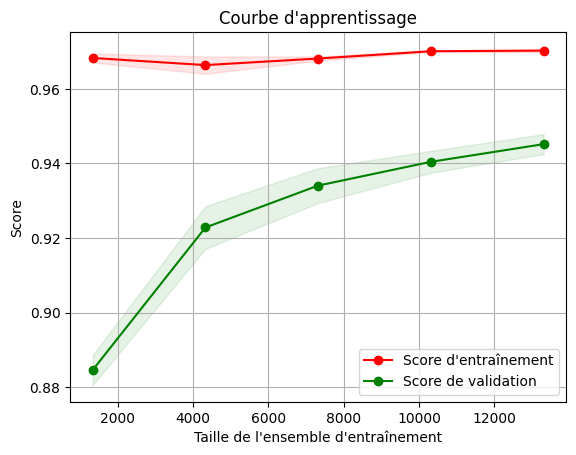

In [34]:

model = LogisticRegression()
model.fit(x1_train, y1_train)

# Prédire les étiquettes sur les données d'entraînement
y1_train_predict = model.predict(x1_test)

# Calculer l'exactitude sur les données d'entraînement
training_data_acc = accuracy_score(y1_test, y1_train_predict)
print(f"Accuracy score: {training_data_acc}")

# Afficher le rapport de classification
target_names = ['Real', 'Fake']
print(classification_report(y1_test, y1_train_predict, target_names=target_names))

# Calculer la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(model, x1_train, y1_train, cv=5, scoring='accuracy')

# Calculer la moyenne et l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation")

plt.legend(loc="best")
plt.show()


In [37]:
import pickle

In [38]:
pickle.dump(model, open("model1.pickle", 'wb')) 

## Pipeline v1

In [46]:

# Créer la pipeline
pipeline = Pipeline([
    ('stemming', FunctionTransformer(stemming)),
    ('vectorizer', TfidfVectorizer()),
    ('model', model)
])

# Entraîner la pipeline sur les données d'entraînement
pipeline.fit(x1_train[0], y1_train[0])

# Prédire les étiquettes sur les données de test
y1_test_predict = pipeline.predict(x1_test)

# Calculer l'exactitude sur les données de test
test_data_acc = accuracy_score(y1_test, y1_test_predict)
print(f"Accuracy score: {test_data_acc}")


ValueError: Iterable over raw text documents expected, string object received.

## XGBoost Classifier

In [29]:
bst = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')

In [30]:
# fit model
bst.fit(x1_train, y1_train)
# make predictions
preds = bst.predict(x1_test)

training_data_acc = accuracy_score(y1_test, preds)
print(f"Accuracy score: {training_data_acc}")

target_names = ['Real', 'Fake']
print(classification_report(y1_test, preds, target_names=target_names))

Accuracy score: 0.9024038461538462
              precision    recall  f1-score   support

        Real       0.90      0.90      0.90      2077
        Fake       0.90      0.90      0.90      2083

    accuracy                           0.90      4160
   macro avg       0.90      0.90      0.90      4160
weighted avg       0.90      0.90      0.90      4160



In [31]:
preds

array([1, 0, 1, ..., 1, 1, 0])

# Test

In [131]:
df_test = pd.read_csv("data/stem_test.csv")

In [132]:
df_test = df_test.fillna('')

In [133]:
df_test

,Unnamed: 0,id,title,author,text,text_stem
0,0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",palo alto calif year scorn polit process silic...
1,1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,russian warship readi strike terrorist near al...
2,2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,video nodapl nativ american leader vow stay wi...
3,3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",first succeed tri differ sport tim tebow heism...
4,4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,min ago view comment like first time histori f...
...,...,...,...,...,...,...
5195,5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,dysfunct plagu world megac none may pernici ba...
5196,5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,washington gov john kasich ohio tuesday sign l...
5197,5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,good morn want get california today email joan...
5198,5198,25998,300 US Marines To Be Deployed To Russian Borde...,,« Previous - Next » 300 US Marines To Be Deplo...,previou next us marin deploy russian border no...


In [97]:
#df_test["text_stem"] = df_test['text'].apply(stemming)

In [98]:
#df_test.to_csv("data/stem_test.csv")

In [146]:
x2 = df_test["text_stem"].values
x2[0]

'palo alto calif year scorn polit process silicon valley leapt fray prospect presid donald j trump push tech commun move beyond tradit role donor embrac new exist agit activist distinguish ventur capit firm emblazon corpor home page earthi epithet one promin tech chieftain say consequ mr trump elect would rang disastr terribl anoth compar dictat nearli tech leader sign open letter decri mr trump campaign anger bigotri quit action peter thiel founder paypal palantir first outsid investor facebook spoke republican convent juli new york time report saturday mr thiel give million support mr trump candidaci even support flee also recent gave million super pac support senat rob portman republican freshman run ohio get involv polit use seen clash silicon valley valu system transform world make problem obsolet solv washington entrepreneur want alien whatev segment custom agre polit retic longer style bunch nerd use lot limelight said dave mcclure investor run tech incub call startup quot great

In [147]:
x2 = vectorizer.transform(x2)

In [148]:
model.predict(x2[0])

ValueError: X has 161730 features, but LogisticRegression is expecting 110429 features as input.

In [40]:
submit = df_test
submission = pd.DataFrame({
    'id': df_test['id'],
    'label': sub
})
submission = submission.set_index("id")

In [41]:
submission.to_csv("submit.csv")

# New Training

In [9]:
new_df = pd.read_csv("data/WELFake_Dataset.csv")
new_df = new_df.drop("Unnamed: 0", axis=1)
new_df["label"] = new_df["label"] .replace({0:1, 1:0})

In [14]:
tot_df = pd.concat([df_train[["title", "text", "label"]],new_df], axis=0)
tot_df

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,1
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",0
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,1
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,1


In [15]:
tot_df = tot_df.fillna(" ")

In [16]:
tot_df['text_stem'] = tot_df['text'].apply(stemming)

In [17]:
tot_df.to_csv("mega_train.csv")

In [18]:
x5 = tot_df["text_stem"]
y5 = tot_df["label"]

In [19]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x5)

x5 = vectorizer.transform(x5)

In [21]:
x5_train,x5_test,y5_train,y5_test = train_test_split(x5,y5,test_size = 0.2, stratify=y5, random_state=2)

## Log_reg Baseline

/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score: 0.7042556625598536
              precision    recall  f1-score   support

        Real       0.69      0.78      0.73      9499
        Fake       0.73      0.63      0.68      9088

    accuracy                           0.70     18587
   macro avg       0.71      0.70      0.70     18587
weighted avg       0.71      0.70      0.70     18587



/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


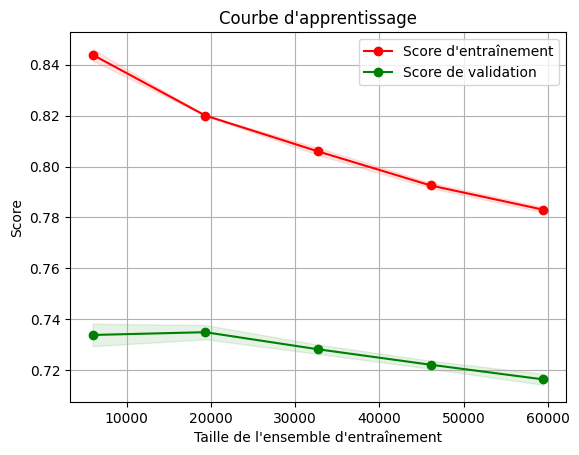

In [25]:
log_reg = LogisticRegression()
log_reg.fit(x5_train, y5_train)

# Prédire les étiquettes sur les données d'entraînement
y5_train_predict = log_reg.predict(x5_test)

# Calculer l'exactitude sur les données d'entraînement
training_data_acc = accuracy_score(y5_test, y5_train_predict)
print(f"Accuracy score: {training_data_acc}")

# Afficher le rapport de classification
target_names = ['Real', 'Fake']
print(classification_report(y5_test, y5_train_predict, target_names=target_names))

# Calculer la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(log_reg, x5_train, y5_train, cv=5, scoring='accuracy')

# Calculer la moyenne et l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation")

plt.legend(loc="best")
plt.show()

## Log_reg ( CV )

Cross-Validation Accuracy: 0.7163301594291106 +/- 0.0021887087613809515
              precision    recall  f1-score   support

        Real       0.69      0.78      0.73      9499
        Fake       0.73      0.63      0.68      9088

    accuracy                           0.70     18587
   macro avg       0.71      0.70      0.70     18587
weighted avg       0.71      0.70      0.70     18587



/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


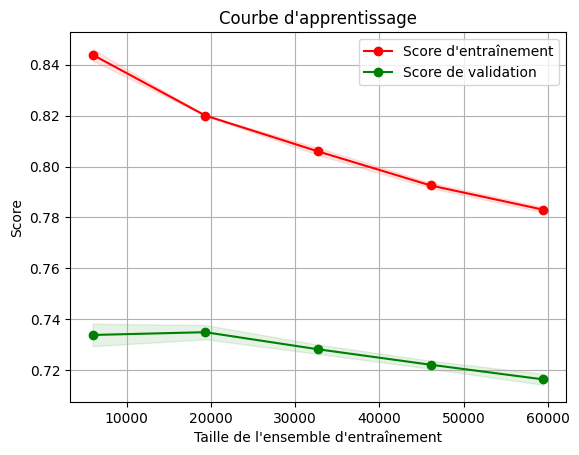

In [28]:
log_reg = LogisticRegression()

# Effectuer la validation croisée
cv_scores = cross_val_score(log_reg, x5_train, y5_train, cv=5, scoring='accuracy')

# Calculer la moyenne et l'écart type des scores de validation croisée
cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)

print(f"Cross-Validation Accuracy: {cv_scores_mean} +/- {cv_scores_std}")

# Afficher le rapport de classification
target_names = ['Real', 'Fake']
print(classification_report(y5_test, y5_train_predict, target_names=target_names))

# Calculer la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(log_reg, x5_train, y5_train, cv=5, scoring='accuracy')

# Calculer la moyenne et l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation")

plt.legend(loc="best")
plt.show()


## XGBoost Classifier

In [30]:
bst = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')

In [31]:
# fit model
bst.fit(x5_train, y5_train)
# make predictions
preds = bst.predict(x5_test)

training_data_acc = accuracy_score(y5_test, preds)
print(f"Accuracy score: {training_data_acc}")

target_names = ['Real', 'Fake']
print(classification_report(y5_test, preds, target_names=target_names))

Accuracy score: 0.73809651907247
              precision    recall  f1-score   support

        Real       0.69      0.87      0.77      9499
        Fake       0.82      0.60      0.69      9088

    accuracy                           0.74     18587
   macro avg       0.75      0.74      0.73     18587
weighted avg       0.75      0.74      0.73     18587

